In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from ontological_processor import OntologicalProcessor
from preprocess_transcription import Preprocessor

# Loading Data

In [3]:
link_to_stuff = '../sample_transcriptions/2021-11-02.txt'
proc = Preprocessor(link_to_stuff)

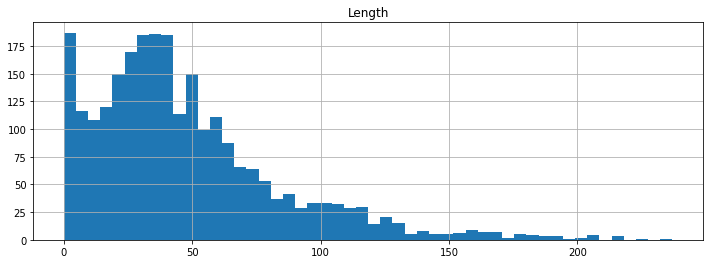

In [4]:
proc.plot_length_distribution()

In [5]:
df = proc.get_transcriptions(15)

In [6]:
df.to_csv('test.csv', index=False)

# Processing

In [7]:
op = OntologicalProcessor()

In [8]:
df['turn'] = df['Transcriptions'].apply(op.find_turn)
df['altitude'] = df['Transcriptions'].apply(op.find_alt)
df['heading'] = df['Transcriptions'].apply(op.find_turn)

<ipython-input-8-b6d33110f4e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['turn'] = df['Transcriptions'].apply(op.find_turn)
<ipython-input-8-b6d33110f4e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['altitude'] = df['Transcriptions'].apply(op.find_alt)
<ipython-input-8-b6d33110f4e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [9]:
df.to_csv('test.csv', index=False)

In [10]:
df['altitude'].value_counts()

NA            1154
Missing KW     232
4000           179
5000           169
Missing ST     146
3000           138
6000            57
7000            14
8000            10
2000             3
1000             2
15000            1
4600             1
300300           1
3700             1
33000            1
2400             1
5200             1
8500             1
9000             1
2300             1
Name: altitude, dtype: int64

In [8]:
string = df['Transcriptions'].iloc[2]

In [10]:
import re

In [16]:
string

'AMERICAN 1583 MAINTAIN 180 KNOTS TO ZALPO CONTACT TOWER NOW 127.5 HAVE AH GOOD DAY'

In [22]:
string_1 = '1808 REDUCE SPEED TO 1 9 0'

while (string_1 != re.sub(r'\d+\s+\d+', change, string_1)):
    string_1 = re.sub(r'\d+\s+\d+', change, string_1)

# regex expression for one digit followed by one space followed by one digit

In [72]:
def find_alt(command):
    command = str.lower(command)
    command = str.split(command)

    number_loc = [i for (i, x) in enumerate(command) if x.isdigit() and (len(x) > 3) and (int(x)%100 == 0)] # Note: the divisibility by 100 excludes speed (and often callsigns)

    # locate the index of ascend
    key_loc = [i for (i, x) in enumerate(command) if (x == 'up') or ('down' in x) or ('descend' in x) or ('ascend' in x) or ('climb' in x) or ('altitude' in x) or ('maintain' in x)]

    # If there exists no keyword, there exists a number devisible by 100 
    if ((len(key_loc) == 0) and (len(number_loc) > 0)):
        return 'Missing KW' # NOTE: this can be used to predict speaker role w/ ML
    # If there exists no number and no command (note: doesn't account for edge case of callsign being divisible by 100)
    elif (len(key_loc)==0):
        return 'NA'
    # key_loc must be populated, but unsure about whether number_loc exists / actual altitude exists
    try:
        filtered_numbers = [i for i in number_loc if i > key_loc[-1]]
        return int(command[filtered_numbers[0]])
    # If above fails, must be because altutde does not exist but keyword exists
    except:
        return 'Missing ST'

    # TODO: use NLTK synonyms instead

In [53]:
find_alt(df['Transcriptions'].iloc[4])

7000

In [44]:
command = df['Transcriptions'].iloc[2]
print(find_alt(command))

AMERICAN 1583 MAINTAIN 180 KNOTS TO ZALPO CONTACT TOWER NOW 127.5 HAVE AH GOOD DAY
['american', '1583', 'maintain', '180', 'knots', 'to', 'zalpo', 'contact', 'tower', 'now', '127.5', 'have', 'ah', 'good', 'day']
[1]
[2]
None


In [75]:
df

,Time,Transcriptions,Length,altitude,turn
51,21-11-02 07:14:45.389,DELTA 1169 APPROACH GOOD MORNING 35 RIGHT,41,True,True
52,21-11-02 07:14:45.698,AMERICAN 1583 AH MILES FROM 3 MAINTAIN 3000 UN...,110,False,False
53,21-11-02 07:14:45.866,AMERICAN 1583 MAINTAIN 180 KNOTS TO ZALPO CONT...,82,False,False
54,21-11-02 07:14:46.199,AMERICAN 14 03 DESCEND AND MAINTAIN 7000,40,False,False
55,21-11-02 07:14:46.364,DELTA 1169 MAINTAIN 7000,24,False,False
56,21-11-02 07:14:46.599,CITATION 7MM HEADING 330 AND INTERCEPT THE LOC...,52,True,True
57,21-11-02 07:14:46.759,AMERICAN 14 03 REDUCE SPEED TO 1 9 0 HEADING 260,48,True,True
58,21-11-02 07:14:47.112,ENVOY 3746 APPROACH GOOD MORNING DESCEND VIA 7...,167,True,True
59,21-11-02 07:14:47.268,REGIONAL APPROACH AMERICAN 1374 OUT OF 6300 DE...,82,False,False
60,21-11-02 07:14:47.547,AMERICAN 1374 REGIONAL APPROACH GOOD MORNING 3...,52,True,True
